<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Deep Learning - Final Assignment</font></h1>


<h1 align="center"><font size="4">Predicting Viscosities using Deep Learning, Physical Model Prameters and Entropy</font></h1>

## Task:

One of the main objectives of this course is to help you gain hands-on experience in communicating insightful and impactful findings to stakeholders. In this project you will use the tools and techniques you learned throughout this course to use deep learning for a task of your choosing. It can be any Deep Learning application for supervised or unsupervised learning. You choose to work on a classification, image, or text application on a data set that you feel passionate about. Then, you will tweak your deep learning model to best suits your needs, and communicate insights you found from your model development exercise.

As a main deliverable, you will submit a report that helps you focus on highlighting your analytical skills, thought process, and next steps.

-    Main objective of the analysis that also specifies whether your model will be focused on a specific type of Deep Learning or Reinforcement Learning algorithm and the benefits that your analysis brings to the business or stakeholders of this data.

-    Brief description of the data set you chose, a summary of its attributes, and an outline of what you are trying to accomplish with this analysis.

-    Brief summary of data exploration and actions taken for data cleaning or feature engineering.

-    Summary of training at least three variations of the Deep Learning model you selected. For example, you can use different clustering techniques or different hyperparameters.

-    A paragraph explaining which of your Deep Learning models you recommend as a final model that best fits your needs in terms of accuracy or explainability.

-    Summary Key Findings and Insights, which walks your reader through the main findings of your modeling exercise.

-    Suggestions for next steps in analyzing this data, which may include suggesting revisiting this model or adding specific data features to achieve a better model.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feos.si import * # SI numbers and constants
from feos.pcsaft import *
from feos.eos import *
import feos

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Multiply
from keras.models import Model

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. About the Data

Read dataset into pandas dataframe:


In [2]:
data_den = pd.read_csv("new_paras.csv")
for col in data_den.columns:
    if "Unnamed" in col:
        data_den = data_den.drop(col,axis=1)

print( np.unique( data_den["phase"] ) )        
print( np.unique( data_den["family_itt"] ) )     

data_den = data_den[ data_den["phase"] != "Vapor" ]
data_den = data_den[ data_den["phase"] != "Vapor (VLE)" ]

data_den = data_den[ data_den["epsilon_k_ab"] == 0 ]
data_den = data_den[ data_den["mu"] == 0 ]


data_den["viscosity"] = data_den["property"]
data_den = data_den.drop("property",axis=1)
data_den["resd_entropy"] = -data_den["resd_entropy"]


data_den = data_den[ data_den["ln_eta_star_new"] < 8.0 ]
data_den = data_den[ data_den["ln_eta_star_new"] > 1.0 ]
data_den = data_den[ data_den["resd_entropy"] > 1.0 ]
data_den = data_den[ data_den["resd_entropy"] < 4.0 ]

#data_den["resd_entropy_0"] = 0.0

print( np.unique( data_den["family_itt"] ) )    
  
    
ffam = "Alkanes"
data_fam = data_den[ data_den["family_itt"] == "Alkenes" ]
data_den = data_den[ data_den["family_itt"] == ffam ]
#data_fam = data_den[ data_den["family_itt"] == ffam ]

print( data_den.shape ) 

data_den

['Liquid' 'Liquid (VLE)' 'Vapor' 'Vapor (VLE)']
['Acids' 'Alcohols' 'Aldehydes' 'Alkanes' 'Alkenes' 'Amines'
 'Aromatic hydrocarbons' 'Chlorides' 'Cyclic compounds' 'Elements'
 'Esters' 'Ethers' 'Fluorides' 'Halogenated compounds'
 'Inorganic compounds' 'Ketones' 'Nitriles' 'Other compounds'
 'Polyfunctional compounds' 'Silanes/siloxanes' 'Sulfides/thiophenes']
['Alkanes' 'Alkenes' 'Aromatic hydrocarbons' 'Chlorides'
 'Cyclic compounds' 'Elements' 'Fluorides' 'Halogenated compounds'
 'Inorganic compounds' 'Other compounds' 'Silanes/siloxanes'
 'Sulfides/thiophenes']
(9605, 49)


,i,temperature,pressure,density,molar_density,value,resd_entropy,database,phase,substance_id,...,opt,kappa_ab,epsilon_k_ab,mu,ln_eta_star,ln_eta_star_new,critical_molar_density,critical_temperature,eta_ref_new,ln_ref_new
2213,5737,323.000000,13310000.0,0.0,9772.229238,0.000150,1.690289,DDB,Liquid,41,...,OptimizeOption.FULL,0.0,0.0,0.0,2.022082,2.865943,3757.549609,434.429146,0.000009,0.000009
2214,5738,323.000000,18030000.0,0.0,9906.600032,0.000160,1.725894,DDB,Liquid,41,...,OptimizeOption.FULL,0.0,0.0,0.0,2.089247,2.933108,3757.549609,434.429146,0.000009,0.000009
2215,5739,323.000000,21980000.0,0.0,10009.452352,0.000169,1.753451,DDB,Liquid,41,...,OptimizeOption.FULL,0.0,0.0,0.0,2.145711,2.989572,3757.549609,434.429146,0.000009,0.000009
2216,5740,323.000000,26850000.0,0.0,10126.467512,0.000178,1.785126,DDB,Liquid,41,...,OptimizeOption.FULL,0.0,0.0,0.0,2.192419,3.036280,3757.549609,434.429146,0.000009,0.000009
2217,5741,323.000000,29760000.0,0.0,10191.995975,0.000186,1.803016,DDB,Liquid,41,...,OptimizeOption.FULL,0.0,0.0,0.0,2.237581,3.081442,3757.549609,434.429146,0.000009,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46431,75934,273.149994,101325.0,0.0,7642.584778,0.000495,2.145538,DIPPR,Liquid,366,...,OptimizeOption.FULL,0.0,0.0,0.0,3.343611,4.353455,2635.211959,504.098314,0.000006,0.000006
46432,75935,288.149994,101325.0,0.0,7488.672165,0.000409,2.019677,DIPPR,Liquid,366,...,OptimizeOption.FULL,0.0,0.0,0.0,3.099469,4.109760,2635.211959,504.098314,0.000007,0.000007
46433,75936,293.149994,101325.0,0.0,7436.832112,0.000385,1.979665,DIPPR,Liquid,366,...,OptimizeOption.FULL,0.0,0.0,0.0,3.021995,4.032450,2635.211959,504.098314,0.000007,0.000007
46434,75937,298.149994,101325.0,0.0,7384.638427,0.000361,1.940533,DIPPR,Liquid,366,...,OptimizeOption.FULL,0.0,0.0,0.0,2.940996,3.951617,2635.211959,504.098314,0.000007,0.000007


As this is a introductionary study, only substances from the chemical family of alkanes are analysed. In addition, only data points that can be assigned to the liquid phase at moderate conditions are selected.

For testing, Alkene data is also stored but will not be used for training.


In [3]:
data_den.shape,  data_fam.shape, len( np.unique( data_den["substance_id"] ) )

((9605, 49), (294, 49), 28)

The dataset contains several columns relevant for the following analysis which can be split into 3 cateories:

physical model parameters (different for every substance):
- m: seqment parameter, represents the molecule length ( float, unitless )
- sigma: bead radius, represents the average radius of a atom in the molecule ( float, angstrom )
- epsilon_k: represents the interaction energy of a atom in the molecule ( float, kelvin )

chemical information (different for every substance):
- molarweight: molarweight of the substance ( float, g/mol )

state point data (different for every sample):
- resd_entropy: reduced residual entropy ( float, negative value (multiplied by -1 to obtain positive values for training), unitless )
- ln_eta_star: logarithm of the reduced residual viscosity with CE reference ( float, unitless )
- ln_eta_star_new: logarithm of the reduced residual viscosity with new reference ( float, unitless )
- viscosity: viscosity ( float, Pa s )

The reduced state point values resd_entropy, ln_eta_star and ln_eta_star_new were calculated from viscosity, temperature and pressure in a pre-step which will not be covered in this assignment.
Values of state point features vary across the entire data set, while substance-specific features only vary substance-specifically. If state point-specific features were eliminated, the result would be a greatly reduced data set that includes around 160 substances or 28 alkanes.


For model training we choose the following features:


In [4]:
y_key = 'ln_eta_star_new'

feature_cols = [ 'm','sigma', 'epsilon_k', 'molarweight', 'resd_entropy' ] 


In [5]:
data_den.columns

Index(['i', 'temperature', 'pressure', 'density', 'molar_density', 'value',
       'resd_entropy', 'database', 'phase', 'substance_id', 'cas',
       'isomeric_smiles', 'family', 'family_itt', 'title', 'authors', 'year',
       'journal', 'quality', 'reference_id', 'datapoint_id', 'id', 'm',
       'sigma', 'epsilon_k', 'viscosity', 'molarweight', 'na', 'nb',
       'mard_vis', 't_min_vis', 't_max_vis', 'points_viscosity', 'date',
       'fit_cost', 'fit_optimality', 'note', 'bounds_violation',
       'resd_entrpy_diff', 'opt', 'kappa_ab', 'epsilon_k_ab', 'mu',
       'ln_eta_star', 'ln_eta_star_new', 'critical_molar_density',
       'critical_temperature', 'eta_ref_new', 'ln_ref_new'],
      dtype='object')

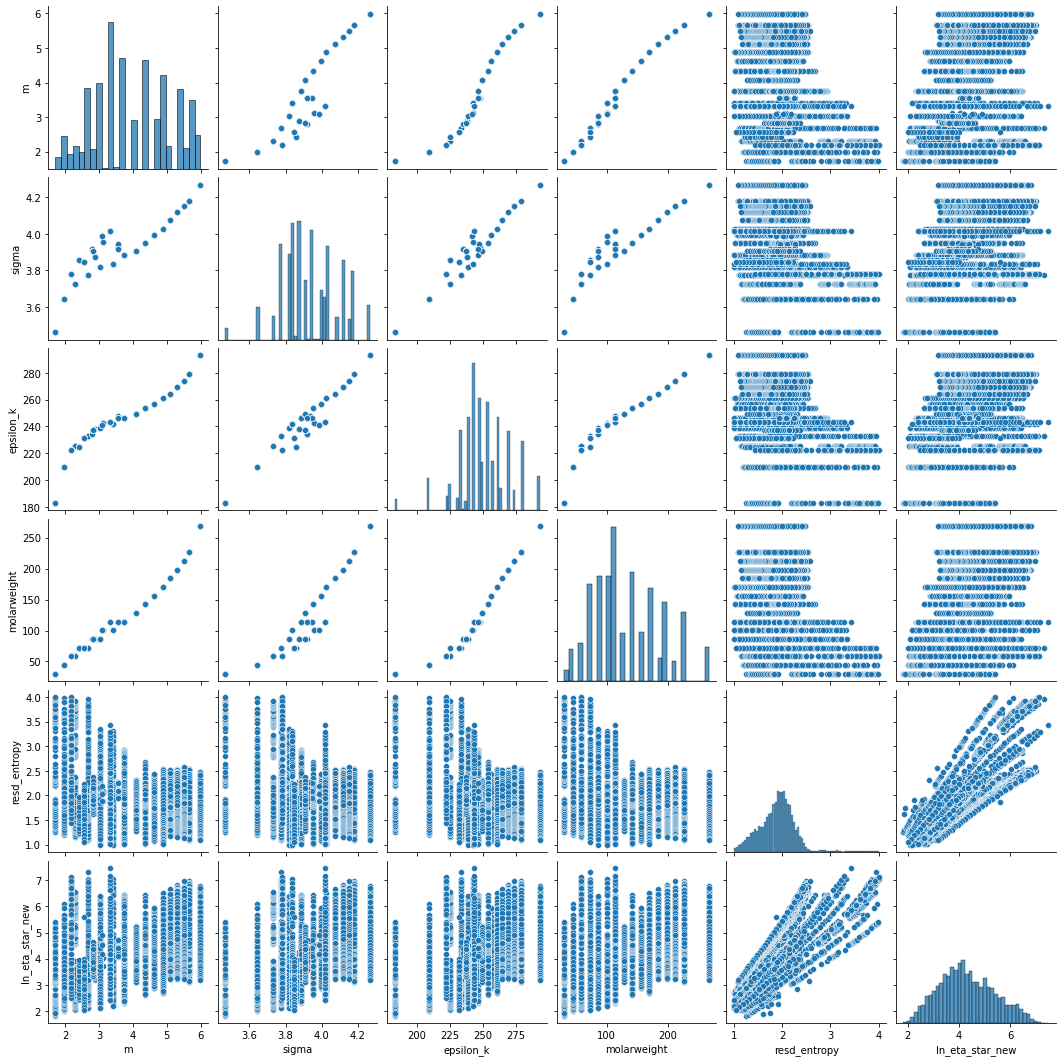

In [7]:
sns.pairplot( data_den[ feature_cols+[y_key] ] ) #, hue='family')

You can clearly see that some features are substance-specific and others are both substance and state point specific.

# 2. Objectives

The goal of this work is to investigate the univariante relationship between reduced residual entropy and log reduced viscosity for a large number of different species.
Initially the relationship was described via linear regression. In the following higher order polynomials were introduced. They are reported to perform better within areas covered by data but lack extrapolation capabilities due to overfitting. 

BUT till now polynomial and linear regression was donne separately for every species.

NOW we want to test if we cann utilize deep learning to predict viscosities for any species based on parameters of the physical model and residual entropies.

We will test three models:

- pass parameters of the physical model and residual entropies to a neural network (NN) and predict ln_eta_star_new
- pass parameters of the physical model to an NN to predict parameters for linear regression within residual entropy space
- pass parameters of the physical model to an NN to predict parameters for a polynomial within residual entropy space

Linear regression and higher order polynomials need to be included into the NN architecture. Here, substance-specific features and substance- as well as state point specific features are treated separately. The architecture is comparable to a RecommenderNet with user and item data as inputs that are treated separately. The names of and within the classes are therefore also based on RecommenderNet. Parameters of the physical model that represent different species are users whereas items are residual entropies and its polynomial features (sorry for that, I was too lazy to rename everything). 

This leads to the following steps:

- split dataset to train and test data
- imlement, initialize, train and test the three approaches
- compare

After those steps we shoul be able to conclude which approach is most useful for application.

## Train, test, val split and polynomial features

For the third model we use polynomial features. We will add them now i.e. before the train test split. It is important to use the same train, val and test datta for all models.



In [9]:
additional_features = 3
additional_feature_names = []

for i in range(additional_features):
    x = i+2
    name = "resd_entropy_"+str(int(x))
    data_den[name] =  data_den["resd_entropy"]**x
    data_fam[name] =  data_fam["resd_entropy"]**x
    additional_feature_names.append(name)
  
    
print("additional_feature_names", additional_feature_names)

additional_feature_names ['resd_entropy_2', 'resd_entropy_3', 'resd_entropy_4']


In [14]:
y_key = 'ln_eta_star_new'

feature_cols = [ 'm','sigma', 'epsilon_k', 'molarweight', 'resd_entropy' ] + additional_feature_names

X_p = np.array( data_den[feature_cols] )
y = np.array( data_den[y_key] )

X_train_p, X_test_p, y_train, y_test = train_test_split(X_p.copy(), y.copy(), test_size=0.2, random_state=123)

X_train_p, X_val_p, y_train, y_val   = train_test_split(X_train_p, y_train, test_size=0.25, random_state=123)


For models one and two we will only use the following features:

In [15]:
feature_cols = [ 'm','sigma', 'epsilon_k', 'molarweight', 'resd_entropy' ]

ii = len( feature_cols )

X_train = X_train_p[:,:ii]
X_val   = X_val_p[:,:ii]
X_test  = X_test_p[:,:ii]
X       = X_p[:,:ii]


X.shape, X_p.shape, len(feature_cols)


((9605, 5), (9605, 8), 5)

# 3. Direct fit of a Neural Network

In a first step we will directly fit a NN ont the training data.
The data set is split into training, validation and test data.

As scaling is part of the model, we have integrated it into the model class. When the model is deployed, the scaling function can be called up directly.

The input layer does not have to be explicitly specified here. We use two hidden dense layers wit ReLu activation and 32 and 1 units. The ouput is one-dimensional. The final ReLu guarantees positive outputs or null.


In [16]:
class RecommenderNet0(keras.Model):
    
    def __init__(self, X , y,                 
                 **kwargs):
        super(RecommenderNet0, self).__init__(**kwargs)

        self.X_max = np.max( X, axis=0 )
        self.X_min = np.min( X, axis=0 )
        self.X_range = self.X_max - self.X_min        
        
        self.y_max = np.max( y, axis=0 )
        self.y_min = np.min( y, axis=0 )
        self.y_range = self.y_max - self.y_min            
        
        self.base_user_layer_0 = Dense(
            32, activation="relu"
        )            
     
        self.base_user_layer_1 = Dense(
            16, activation="relu"
        )            

        self.base_user_layer_x = Dense(
            1, activation="relu"
        )                  

    def scale(self, X,y):
        X = X - self.X_min
        X = X / self.X_range      
        
        y = y - self.y_min
        y = y / self.y_range      
        return X, y
        
    def unscale(self, X,y):
        X = X * self.X_range
        X = X + self.X_min
        
        y = y * self.y_range
        y = y + self.y_min        
        return X, y
        
        
    def call(self, inputs):
        base_user_hid    = self.base_user_layer_0( inputs )
        #base_user_hid    = self.base_user_layer_1( base_user_hid )
        base_user_vector = self.base_user_layer_x( base_user_hid )        
        return tf.nn.relu(base_user_vector)


model0 = RecommenderNet0(  X_train, y_train )    

X_scaled, y_scaled = model0.scale(X, y )
X_train_scaled, y_train_scaled = model0.scale(X_train, y_train )
X_test_scaled, y_test_scaled  = model0.scale(X_test, y_test )
X_val_scaled, y_val_scaled   = model0.scale(X_val, y_val)


model0.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError() ,
    metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()])


loss = []
val_loss = []
rmse = []
val_rmse = []
test_rmse = []
test_loss = []
n_epochs = []
test_acc = []
val_acc = []
acc = []

Now we train the model:

46/46 [==============================] - 1s 4ms/step - loss: 0.1652 - accuracy: 1.7352e-04 - root_mean_squared_error: 0.4064 - val_loss: 0.0269 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.1640
test_loss: 0.027139833196997643 test_rmse: 0.16474170982837677

46/46 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.1279 - val_loss: 0.0121 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.1101
test_loss: 0.012139723636209965 test_rmse: 0.11018041521310806

46/46 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0966 - val_loss: 0.0072 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0850
test_loss: 0.007112663239240646 test_rmse: 0.08433660864830017

46/46 [==============================] - 0s 2ms/step - loss: 0.0058 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0759 - val_loss: 0.0049 - val_accuracy: 0.0000e+00 - val_root

46/46 [==============================] - 0s 2ms/step - loss: 1.7424e-04 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0132 - val_loss: 2.5520e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0160
test_loss: 0.00016529991989955306 test_rmse: 0.012856901623308659

46/46 [==============================] - 0s 2ms/step - loss: 1.7773e-04 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0133 - val_loss: 2.6003e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0161
test_loss: 0.00017064552230294794 test_rmse: 0.01306313555687666

46/46 [==============================] - 0s 2ms/step - loss: 1.7294e-04 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0132 - val_loss: 2.4218e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0156
test_loss: 0.00015437773254234344 test_rmse: 0.012424883432686329

46/46 [==============================] - 0s 2ms/step - loss: 1.6600e-04 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0129 - val_loss: 2.4021e-

46/46 [==============================] - 0s 2ms/step - loss: 1.2736e-04 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0113 - val_loss: 2.1829e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0148
test_loss: 0.00013496458996087313 test_rmse: 0.011617425829172134

46/46 [==============================] - 0s 2ms/step - loss: 1.2919e-04 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0114 - val_loss: 2.0245e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0142
test_loss: 0.00011877539509441704 test_rmse: 0.010898412205278873



[0.16474170982837677,
 0.11018041521310806,
 0.08433660864830017,
 0.06908056139945984,
 0.05640345439314842,
 0.045578718185424805,
 0.03636506199836731,
 0.030385877937078476,
 0.026833122596144676,
 0.02410062775015831,
 0.022048145532608032,
 0.02065359055995941,
 0.019611863419413567,
 0.018441708758473396,
 0.01760575920343399,
 0.017789926379919052,
 0.016563182696700096,
 0.016301605850458145,
 0.01560615748167038,
 0.015160770155489445,
 0.01522284559905529,
 0.014348499476909637,
 0.013986019417643547,
 0.014381342567503452,
 0.013377325609326363,
 0.013133586384356022,
 0.013044469058513641,
 0.012872390449047089,
 0.012754468247294426,
 0.012856901623308659,
 0.01306313555687666,
 0.012424883432686329,
 0.012376788072288036,
 0.012813402339816093,
 0.01221373863518238,
 0.012124694883823395,
 0.012342915870249271,
 0.012243201024830341,
 0.012892335653305054,
 0.012724243104457855,
 0.01204566191881895,
 0.011847307905554771,
 0.011736963875591755,
 0.011725930497050285,
 0

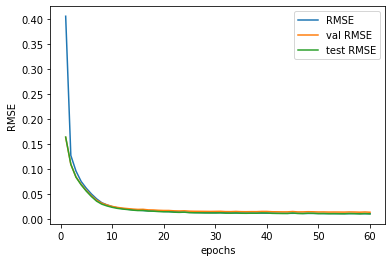

In [17]:
epochs = np.arange(60)+1



for epoch in epochs:
    his = model0.fit(x=X_train_scaled,y=y_train_scaled,
                    epochs=1,
                    batch_size=128,
                    validation_data=(X_val_scaled, y_val_scaled),
                    shuffle=True,
                    verbose=1)

    # update dictionaries
    loss.append(his.history['loss'][0])
    val_loss.append(his.history['val_loss'][0])
    acc.append(his.history['accuracy'][0])
    val_acc.append(his.history['val_accuracy'][0])    
    rmse.append(his.history['root_mean_squared_error'][0])
    val_rmse.append(his.history['val_root_mean_squared_error'][0])   
    
    t_loss, t_acc , t_rmse = model0.evaluate(X_test_scaled, y_test_scaled, verbose=0)
    test_rmse.append(t_rmse)
    test_loss.append(t_loss)
    test_acc.append(t_acc)
    print( "test_loss:",t_loss, "test_rmse:",t_rmse )
    if n_epochs:
        n_epochs.append(n_epochs[-1]+1)
    else:
        n_epochs.append(1)
    print("")

    
plt.plot( n_epochs, rmse, label="RMSE" )
plt.plot( n_epochs, val_rmse, label="val RMSE"  )
plt.plot( n_epochs, test_rmse, label="test RMSE"  )
plt.legend()
plt.xlabel("epochs")
plt.ylabel("RMSE") 
test_rmse

The model converged properly. Now we can check the predictive capabilities:

In [18]:
y_pred_train = model0.predict(X_train_scaled)
y_pred_val = model0.predict(X_val_scaled)
y_pred_test = model0.predict(X_test_scaled)
y_pred = model0.predict(X_scaled)

301/301 [==============================] - 0s 703us/step


Text(0, 0.5, 'predictions')

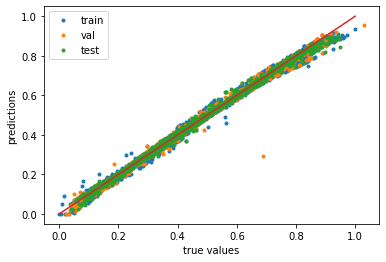

In [19]:
plt.plot( y_train_scaled,y_pred_train, ".", label="train" )
plt.plot( y_val_scaled,y_pred_val, ".", label="val" )
plt.plot( y_test_scaled,y_pred_test, ".", label="test" )
plt.plot( [0,1],[0,1],"-" )
plt.legend()

plt.xlabel("true values")
plt.ylabel("predictions")


The comparison of reference and prediction shows a good performance. However, it is noticeable that the upper and lower limits are somewhat frayed and bended. Therefore, one should not extrapolate beyond this (if not stay away from these limits with predictions).

Text(0, 0.5, 'viscosity')

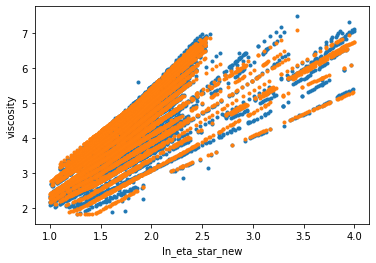

In [20]:
_,yy = model0.unscale( X, y_pred )

plt.plot( X[:,-1], y, "."  )
plt.plot( X[:,-1], yy, "."  )

plt.xlabel("ln_eta_star_new")
plt.ylabel("viscosity")


In this plot you can see that the model can clearly distinguish between the individual substances. Some areas are mapped very poorly. In some cases, positive values (of the normalised date) even had to be forced by the final ReLu (kink at bottom left).

true error 3.9425016258901797 %


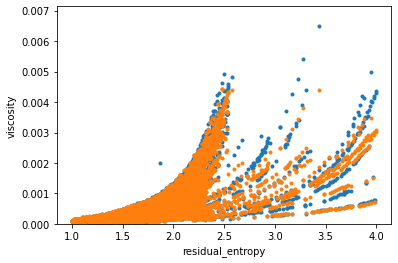

In [21]:
y_true = data_den["value"] #np.exp( funscale(y_fam) ) 

y_pred_true = np.exp( np.squeeze( yy ) ) * data_den["eta_ref_new"]

error_true = np.mean( np.absolute( y_true - y_pred_true )/y_true )


plt.plot( X[:,-1],y_true, "." )
plt.plot( X[:,-1],y_pred_true, "." )

plt.ylim( 0, np.max(y_true)*1.1 )

plt.xlabel("residual_entropy")
plt.ylabel("viscosity")

print("true error", error_true*100, "%")

The model works well. However, it is relatively difficult to train (depending on the start parameters, sometimes nothing happens in the fit). Since some areas are mapped rather poorly (residual_entropy > 2.5), the low error could be a result of local overfitting.

10/10 [==============================] - 0s 948us/step
true test 13.029009992562074 %


(0.0001021085272575111, 0.13029009992562074)

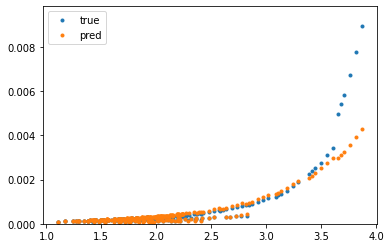

In [22]:
X_fam = np.array( data_fam[feature_cols] )
y_fam = np.array( data_fam[y_key] )

X_fam_scaled, y_fam_scaled = model0.scale(X_fam, y_fam)

y_fam_predict = model0.predict( X_fam_scaled )

y_true = data_fam["value"] #np.exp( funscale(y_fam) ) 

_,yy = model0.unscale( X, y_fam_predict )

y_pred_true = np.exp( np.squeeze( yy ) ) * data_fam["eta_ref_new"]

error_true_fam = mean_absolute_error( y_true, y_pred_true  )
test = np.mean( np.absolute( y_true - y_pred_true )/y_true )

plt.plot( X_fam[:,-1],y_true, ".", label="true" )
plt.plot( X_fam[:,-1],y_pred_true, ".", label="pred" )

plt.ylim( 0, np.max(y_true)*1.1 )
#plt.ylim( 0, 0.002 )
plt.legend()

print("true test", test*100, "%")

error_true_fam, test

The model can also predict substances from other but alkane-like groups such as alkenes.


All in all, viscosities can be predicted surprisingly well based on the parameters of a physical model.


# 4. Neural Network based Linear Model

Now we will train a NN to predict the the gradient of a straight line intersecting the origin. Inputs of the NN are only the parameters of the physical model. The line is only a function of residual_entropy which is just passed through the model but not used to train the NN. This is a kind of minimal model that is easy to train and can robustly extrapolate to state points outside the region used in training. Here the scaling is definitely part of the model and we integrated it into the model class. When the model is deployed, the scaling function can be called up directly.

The data set is split into training, validation and test data.


We use the same architecture with input layer does not explicitly specified. We use two hidden dense layers wit ReLu activation and 32 and 1 units. The ouput is one-dimensional. The final ReLu guarantees positive outputs or null.

In [23]:
class RecommenderNet1(keras.Model):
    
    def __init__(self, num_users, X , y,                 
                 **kwargs):
        super(RecommenderNet1, self).__init__(**kwargs)

        self.num_users = num_users

        self.X_max = np.max( X, axis=0 )
        self.X_min = np.min( X, axis=0 )
        self.X_min[-1] = 0.0
        self.X_range = self.X_max - self.X_min        
        
        self.y_max = np.max( y, axis=0 )
        self.y_min = np.min( y, axis=0 )
        self.y_min = 0
        self.y_range = self.y_max - self.y_min                   
        
        self.base_user_layer_0 = Dense(
            32, activation="relu"
        )            
     
        self.base_user_layer_1 = Dense(
            16, activation="relu"
        )            

        self.base_user_layer_x = Dense(
            1, activation="relu"
        )                  

    def scale(self, X,y):
        X = X - self.X_min
        X = X / self.X_range      
        
        y = y - self.y_min
        y = y / self.y_range      
        return X, y
        
    def unscale(self, X,y):
        X = X * self.X_range
        X = X + self.X_min
        
        y = y * self.y_range
        y = y + self.y_min        
        return X, y
           
    def call(self, inputs):
        # split vector into users and items
        users, items = tf.split( inputs, [self.num_users, 1], 1)
        
        # nonlinear relations
        #user_hid    = self.user_layer_0( inputs )
        #user_hid = self.user_layer_1( user_hid )
        #user_vector = self.user_layer_x( user_hid )

        # linear relations
        base_user_hid    = self.base_user_layer_0( users )
        #base_user_hid    = self.base_user_layer_1( base_user_hid )
        base_user_vector = self.base_user_layer_x( base_user_hid )        
        
        x = base_user_vector*items
        return tf.nn.relu(x)


    
p_no = len(feature_cols)-1


model1 = RecommenderNet1( p_no, X_train, y_train )    

X_scaled, y_scaled = model1.scale(X, y )
X_train_scaled, y_train_scaled = model1.scale(X_train, y_train )
X_test_scaled, y_test_scaled  = model1.scale(X_test, y_test )
X_val_scaled, y_val_scaled   = model1.scale(X_val, y_val)


model1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError() ,
    metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()])


loss = []
val_loss = []
rmse = []
val_rmse = []
test_rmse = []
test_loss = []
n_epochs = []
test_acc = []
val_acc = []
acc = []

46/46 [==============================] - 1s 4ms/step - loss: 0.1279 - accuracy: 0.0000e+00 - root_mean_squared_error: 0.3577 - val_loss: 0.0358 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.1892
test_loss: 0.03567637503147125 test_rmse: 0.18888190388679504

46/46 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 1.7352e-04 - root_mean_squared_error: 0.1300 - val_loss: 0.0095 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0973
test_loss: 0.009495138190686703 test_rmse: 0.09744299948215485

46/46 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 1.7352e-04 - root_mean_squared_error: 0.0962 - val_loss: 0.0078 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0881
test_loss: 0.007775178644806147 test_rmse: 0.08817697316408157

46/46 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 1.7352e-04 - root_mean_squared_error: 0.0868 - val_loss: 0.0062 - val_accuracy: 0.0000e+00 - val_root_

46/46 [==============================] - 0s 2ms/step - loss: 3.0891e-04 - accuracy: 1.7352e-04 - root_mean_squared_error: 0.0176 - val_loss: 3.2356e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0180
test_loss: 0.00027231176500208676 test_rmse: 0.01650187186896801

46/46 [==============================] - 0s 2ms/step - loss: 2.9684e-04 - accuracy: 1.7352e-04 - root_mean_squared_error: 0.0172 - val_loss: 3.1234e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0177
test_loss: 0.00026202920707874 test_rmse: 0.016187315806746483

46/46 [==============================] - 0s 2ms/step - loss: 2.8813e-04 - accuracy: 1.7352e-04 - root_mean_squared_error: 0.0170 - val_loss: 3.0294e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0174
test_loss: 0.00025402093888260424 test_rmse: 0.015938034281134605

46/46 [==============================] - 0s 2ms/step - loss: 2.7832e-04 - accuracy: 1.7352e-04 - root_mean_squared_error: 0.0167 - val_loss: 2.9530e-04 

46/46 [==============================] - 0s 2ms/step - loss: 1.5309e-04 - accuracy: 1.7352e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.8836e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0137
test_loss: 0.00013920155470259488 test_rmse: 0.011798370629549026

46/46 [==============================] - 0s 2ms/step - loss: 1.5031e-04 - accuracy: 1.7352e-04 - root_mean_squared_error: 0.0123 - val_loss: 1.8602e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0136
test_loss: 0.0001370637764921412 test_rmse: 0.011707424186170101



Text(0, 0.5, 'RMSE')

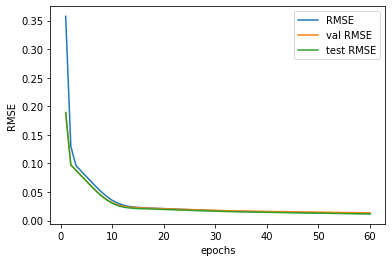

In [24]:
epochs = np.arange(60)+1



for epoch in epochs:
    his = model1.fit(x=X_train_scaled,y=y_train_scaled,
                    epochs=1,
                    batch_size=128,
                    validation_data=(X_val_scaled, y_val_scaled),
                    shuffle=True,
                    verbose=1)

    # update dictionaries
    loss.append(his.history['loss'][0])
    val_loss.append(his.history['val_loss'][0])
    acc.append(his.history['accuracy'][0])
    val_acc.append(his.history['val_accuracy'][0])    
    rmse.append(his.history['root_mean_squared_error'][0])
    val_rmse.append(his.history['val_root_mean_squared_error'][0])   
    
    t_loss, t_acc , t_rmse = model1.evaluate(X_test_scaled, y_test_scaled, verbose=0)
    test_rmse.append(t_rmse)
    test_loss.append(t_loss)
    test_acc.append(t_acc)
    print( "test_loss:",t_loss, "test_rmse:",t_rmse )
    if n_epochs:
        n_epochs.append(n_epochs[-1]+1)
    else:
        n_epochs.append(1)
    print("")

    
plt.plot( n_epochs, rmse, label="RMSE" )
plt.plot( n_epochs, val_rmse, label="val RMSE"  )
plt.plot( n_epochs, test_rmse, label="test RMSE"  )
plt.legend()
plt.xlabel("epochs")
plt.ylabel("RMSE") 


In [25]:
y_pred_train = model1.predict(X_train_scaled)
y_pred_val = model1.predict(X_val_scaled)
y_pred_test = model1.predict(X_test_scaled)
y_pred = model1.predict(X_scaled)

301/301 [==============================] - 0s 859us/step


Text(0, 0.5, 'predictions')

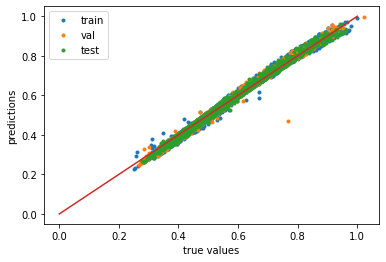

In [26]:
plt.plot( y_train_scaled,y_pred_train, ".", label="train" )
plt.plot( y_val_scaled,y_pred_val, ".", label="val" )
plt.plot( y_test_scaled,y_pred_test, ".", label="test" )
plt.plot( [0,1],[0,1],"-" )
plt.legend()


plt.xlabel("true values")
plt.ylabel("predictions")


Text(0, 0.5, 'viscosity')

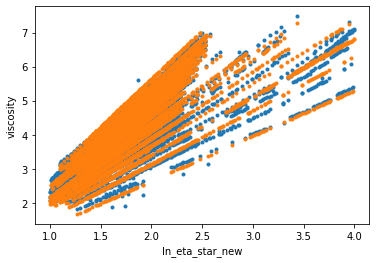

In [27]:
_,yy = model1.unscale( X, y_pred )

plt.plot( X[:,-1], y, "."  )
plt.plot( X[:,-1], yy, "."  )

plt.xlabel("ln_eta_star_new")
plt.ylabel("viscosity")


Here you can see that it is a linear approach. All lines are straight.

true error 6.471778730541552 %


Text(0, 0.5, 'viscosity')

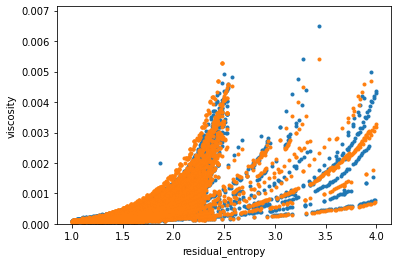

In [28]:
y_true = data_den["value"] #np.exp( funscale(y_fam) ) 

y_pred_true = np.exp( np.squeeze( yy ) ) * data_den["eta_ref_new"]

error_true = np.mean( np.absolute( y_true - y_pred_true )/y_true )

plt.plot( X[:,-1],y_true, "." )
plt.plot( X[:,-1],y_pred_true, "." )

plt.ylim( 0, np.max(y_true)*1.1 )

print("true error", error_true*100, "%")

plt.xlabel("residual_entropy")
plt.ylabel("viscosity")



10/10 [==============================] - 0s 1ms/step
true test 17.16659959333862 %


(0.00010478648932046264, 0.1716659959333862)

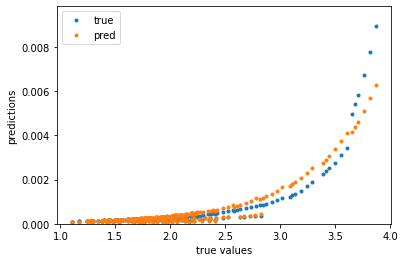

In [29]:
X_fam = np.array( data_fam[feature_cols] )
y_fam = np.array( data_fam[y_key] )

X_fam_scaled, y_fam_scaled = model1.scale(X_fam, y_fam)

y_fam_predict = model1.predict( X_fam_scaled )

y_true = data_fam["value"] #np.exp( funscale(y_fam) ) 

_,yy = model1.unscale( X, y_fam_predict )

y_pred_true = np.exp( np.squeeze( yy ) ) * data_fam["eta_ref_new"]

error_true_fam = mean_absolute_error( y_true, y_pred_true  )
test = np.mean( np.absolute( y_true - y_pred_true )/y_true )

plt.plot( X_fam[:,-1],y_true, ".", label="true" )
plt.plot( X_fam[:,-1],y_pred_true, ".", label="pred" )

plt.ylim( 0, np.max(y_true)*1.1 )
#plt.ylim( 0, 0.002 )
plt.legend()

plt.xlabel("true values")
plt.ylabel("predictions")

print("true test", test*100, "%")

error_true_fam, test

Despite its simplicity, this model performs surprisingly well and represents a good minimal approach.

# 5. Neural Network based Polynomial Model

Now we will train a NN to predict the parameters of a polynomial. Inputs of the NN are only the parameters of the physical model. The polynomial is only a function of residual_entropy which is just passed through the model but not used to train the NN.

This model should represent a good middle ground between an exclusively NN-based solution and the linear approach. It should be is easy to train and might somehow robustly extrapolate to state points outside the region used in training. The scaling is part of the model and we integrated it into the model class. When the model is deployed, the scaling function can be called up directly.

The data set is split into training, validation and test data.

We use the same architecture with input layer does not explicitly specified. We use two hidden dense layers wit ReLu activation and 32 and 1 units. The ouput is one-dimensional. The final ReLu guarantees positive outputs or null.

Now we need to include polynomial features.


In [46]:
y_key = 'ln_eta_star_new'

feature_cols = [ 'm','sigma', 'epsilon_k', 'molarweight', 'resd_entropy' ] + additional_feature_names
#feats = [ 'resd_entropy', 'm','sigma', 'epsilon_k',  ]


In [47]:
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items,
                 X , y,                 
                 **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        
        self.num_users = num_users
        self.num_items = num_items

        print( num_users, num_items )
        
        #self.X_max = np.max( X[:,1:], axis=0 )
        #self.X_min = np.min( X[:,1:], axis=0 )
        #self.X_range = self.X_max - self.X_min

        self.X_max = np.max( X, axis=0 )
        self.X_min = np.min( X, axis=0 )
        self.X_range = self.X_max - self.X_min        
        
        self.y_max = np.max( y, axis=0 )
        self.y_min = np.min( y, axis=0 )
        self.y_range = self.y_max - self.y_min            
        
        self.base_user_layer_0 = Dense(
            32, activation="relu"
        )            
     
        self.base_user_layer_1 = Dense(
            16, activation="relu"
        )            

        self.base_user_layer_x = Dense(
            num_items+1, activation="relu"
        )                  
        
        
        self.user_layer_0 = Dense(
            32, activation="relu"
        )        
       
        
        self.item_layer_0 = Dense(
            32, activation="relu"
        )           
        
        self.user_layer_1 = Dense(
            16, activation="relu"
        )        
        
        self.user_layer_x = Dense(
            1, activation="relu"
        )        
        
        
        self.item_in_layer = Input(
            shape=(num_items,)
        )        

        
        self.xlayer = Dense( 1, activation="relu" )

        
    def scale(self, X,y):
        #X[:,1:] = X[:,1:] - self.X_min
        #X[:,1:] = X[:,1:] / self.X_range
        X = X - self.X_min
        X = X / self.X_range      
        
        y = y - self.y_min
        y = y / self.y_range      
        return X, y
        
    def unscale(self, X,y):
        X = X * self.X_range
        X = X + self.X_min
        
        y = y * self.y_range
        y = y + self.y_min        
        
        #X[:,1:] = X[:,1:] * self.X_range
        #X[:,1:] = X[:,1:] + self.X_min   
        return X, y
        
        
    def call(self, inputs):
        # split vector into users and items
        users, items = tf.split( inputs, [self.num_users, self.num_items], 1)
        
        # nonlinear relations
        #user_hid    = self.user_layer_0( inputs )
        #user_hid = self.user_layer_1( user_hid )
        #user_vector = self.user_layer_x( user_hid )

        # linear relations
        base_user_hid    = self.base_user_layer_0( users )
        #base_user_hid    = self.base_user_layer_1( base_user_hid )#
        base_user_vector = self.base_user_layer_x( base_user_hid )        
        user_vector, base = tf.split( base_user_vector, [self.num_items, 1], 1)
        
        
        xx = user_vector*items
        x = tf.reduce_sum(xx, axis=1, keepdims=True)  #self.sum( xx )
        #print(x.shape, user_vector.shape)
        x = x + base 

        return tf.nn.relu(x)


    
p_no = len(feature_cols)-1-additional_features
i_no = additional_features +1
print(p_no, i_no)
model = RecommenderNet( p_no, i_no, X_train_p, y_train )    
    
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
#                 loss=tf.keras.losses.MeanSquaredError() ,
#                 metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()])


X_scaled, y_scaled = model.scale(X_p, y )
X_train_scaled, y_train_scaled = model.scale(X_train_p, y_train )
X_test_scaled, y_test_scaled  = model.scale(X_test_p, y_test )
X_val_scaled, y_val_scaled   = model.scale(X_val_p, y_val)


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError() ,
    metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()])


loss = []
val_loss = []
rmse = []
val_rmse = []
test_rmse = []
test_loss = []
n_epochs = []
test_acc = []
val_acc = []
acc = []

4 4
4 4


user*items (None, 4)
sumxx (None, 1)
base (None, 1)
x+base (None, 1)
done
user*items (None, 4)
sumxx (None, 1)
base (None, 1)
x+base (None, 1)
done
 1/46 [..............................] - ETA: 16s - loss: 0.0502 - accuracy: 0.0000e+00 - root_mean_squared_error: 0.2241user*items (None, 4)
sumxx (None, 1)
base (None, 1)
x+base (None, 1)
done
46/46 [==============================] - 1s 4ms/step - loss: 0.0200 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.1413 - val_loss: 0.0110 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.1051
test_loss: 0.010712159797549248 test_rmse: 0.10349956154823303

46/46 [==============================] - 0s 2ms/step - loss: 0.0078 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0883 - val_loss: 0.0052 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0718
test_loss: 0.004880050662904978 test_rmse: 0.06985735893249512

46/46 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 3.4704e-04 - root_mean_squared_

46/46 [==============================] - 0s 2ms/step - loss: 1.6684e-04 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0129 - val_loss: 2.5507e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0160
test_loss: 0.0001398865133523941 test_rmse: 0.011827362701296806

46/46 [==============================] - 0s 2ms/step - loss: 1.5454e-04 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0124 - val_loss: 2.4391e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0156
test_loss: 0.00013105296238791198 test_rmse: 0.011447836644947529

46/46 [==============================] - 0s 2ms/step - loss: 1.4520e-04 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0120 - val_loss: 2.3502e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0153
test_loss: 0.00012300818343646824 test_rmse: 0.011090905405580997

46/46 [==============================] - 0s 2ms/step - loss: 1.3690e-04 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0117 - val_loss: 2.2859e-

46/46 [==============================] - 0s 2ms/step - loss: 9.7640e-05 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0099 - val_loss: 1.7378e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0132
test_loss: 7.799355080351233e-05 test_rmse: 0.008831395767629147

46/46 [==============================] - 0s 2ms/step - loss: 8.6585e-05 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0093 - val_loss: 1.7335e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0132
test_loss: 7.922618533484638e-05 test_rmse: 0.008900909684598446

46/46 [==============================] - 0s 2ms/step - loss: 8.6662e-05 - accuracy: 3.4704e-04 - root_mean_squared_error: 0.0093 - val_loss: 1.6789e-04 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.0130
test_loss: 7.200008985819295e-05 test_rmse: 0.008485286496579647



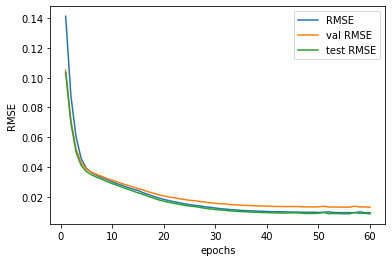

In [48]:
epochs = np.arange(60)+1



for epoch in epochs:
    his = model.fit(x=X_train_scaled,y=y_train_scaled,
                    epochs=1,
                    batch_size=128,
                    validation_data=(X_val_scaled, y_val_scaled),
                    shuffle=True,
                    verbose=1)

    # update dictionaries
    loss.append(his.history['loss'][0])
    val_loss.append(his.history['val_loss'][0])
    acc.append(his.history['accuracy'][0])
    val_acc.append(his.history['val_accuracy'][0])    
    rmse.append(his.history['root_mean_squared_error'][0])
    val_rmse.append(his.history['val_root_mean_squared_error'][0])   
    
    t_loss, t_acc , t_rmse = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
    test_rmse.append(t_rmse)
    test_loss.append(t_loss)
    test_acc.append(t_acc)
    print( "test_loss:",t_loss, "test_rmse:",t_rmse )
    if n_epochs:
        n_epochs.append(n_epochs[-1]+1)
    else:
        n_epochs.append(1)
    print("")

    
plt.plot( n_epochs, rmse, label="RMSE" )
plt.plot( n_epochs, val_rmse, label="val RMSE"  )
plt.plot( n_epochs, test_rmse, label="test RMSE"  )
plt.legend()
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.savefig("tf_initial_training_rmse_4.png")   


In [49]:
y_pred_train = model.predict(X_train_scaled)
y_pred_val = model.predict(X_val_scaled)
y_pred_test = model.predict(X_test_scaled)
y_pred = model.predict(X_scaled)

user*items (None, 4)
sumxx (None, 1)
base (None, 1)
x+base (None, 1)
done
301/301 [==============================] - 0s 900us/step


Text(0, 0.5, 'predictions')

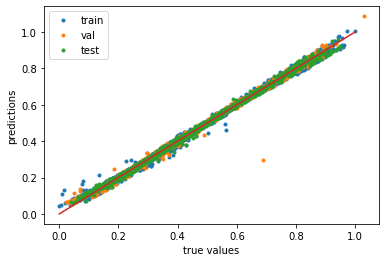

In [50]:
plt.plot( y_train_scaled,y_pred_train, ".", label="train" )
plt.plot( y_val_scaled,y_pred_val, ".", label="val" )
plt.plot( y_test_scaled,y_pred_test, ".", label="test" )
plt.plot( [0,1],[0,1],"-" )
plt.legend()


plt.xlabel("true values")
plt.ylabel("predictions")


The comparison of reference and prediction shows a good performance. Compared to the full NN model, the upper and lower limits are not frayed and are also not bent.

Therefore, this model should be more trustworthy at the borders and beyond the known entropy space.


true test 3.334172609065637 %


(2.775656050240033e-05, 0.03334172609065637)

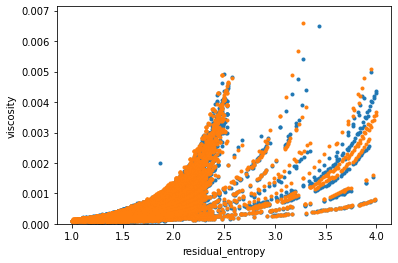

In [51]:
y_true = data_den["value"] #np.exp( funscale(y_fam) ) 

_,yy = model.unscale( X_p, y_pred )

y_pred_true = np.exp( np.squeeze( yy ) ) * data_den["eta_ref_new"]

test = np.mean( np.absolute( y_true - y_pred_true )/y_true )
error_true = mean_absolute_error( y_true, y_pred_true  )

ii = additional_features+1

plt.plot( X_p[:,-ii],y_true, "." )
plt.plot( X_p[:,-ii],y_pred_true, "." )

plt.ylim( 0, np.max(y_true)*1.1 )


plt.xlabel("residual_entropy")
plt.ylabel("viscosity")


print("true test", test*100, "%")
error_true, test,

The prediction accuracy is slightly better than that of the full NN model.



Text(0, 0.5, 'viscosity')

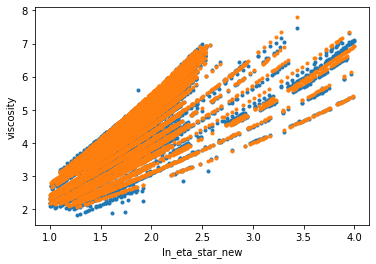

In [52]:
plt.plot( X_p[:,-ii], y, "."  )
plt.plot( X_p[:,-ii], yy, "."  )

plt.xlabel("ln_eta_star_new")
plt.ylabel("viscosity")


The visual overlap between test data and prediction is also higher. In the full NN model, there are areas that are described very poorly. These are better described here.

In [53]:
X_fam = np.array( data_fam[feature_cols] )
y_fam = np.array( data_fam[y_key] )

X_fam_scaled, y_fam_scaled = model.scale(X_fam, y_fam)

y_fam_predict = model.predict( X_fam_scaled )


10/10 [==============================] - 0s 724us/step


true test 7.450635538343933 %


(6.010675805016858e-05, 0.07450635538343933)

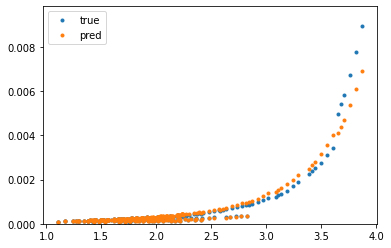

In [54]:
y_true = data_fam["value"] #np.exp( funscale(y_fam) ) 

_,yy = model.unscale( X_p, y_fam_predict )

y_pred_true = np.exp( np.squeeze( yy ) ) * data_fam["eta_ref_new"]

error_true_fam = mean_absolute_error( y_true, y_pred_true  )
test = np.mean( np.absolute( y_true - y_pred_true )/y_true )

plt.plot( X_fam[:,-ii],y_true, ".", label="true" )
plt.plot( X_fam[:,-ii],y_pred_true, ".", label="pred" )

plt.ylim( 0, np.max(y_true)*1.1 )
#plt.ylim( 0, 0.002 )
plt.legend()

print("true test", test*100, "%")

error_true_fam, test

Text(0, 0.5, 'viscosity')

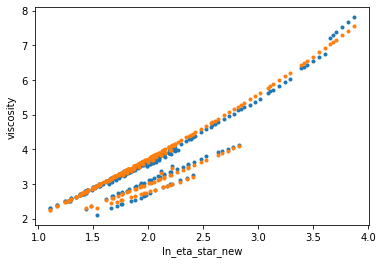

In [55]:
plt.plot( X_fam[:,-ii], y_fam, "."  )
plt.plot( X_fam[:,-ii], yy, "."  )

plt.xlabel("ln_eta_star_new")
plt.ylabel("viscosity")


Text(0, 0.5, 'predictions')

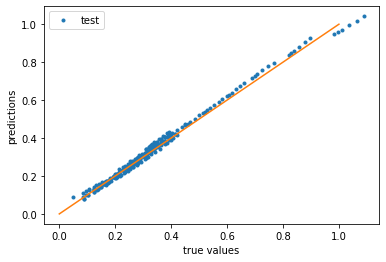

In [56]:
plt.plot( y_fam_scaled,y_fam_predict, ".", label="test" )
plt.plot( [0,1],[0,1],"-" )
plt.legend()


plt.xlabel("true values")
plt.ylabel("predictions")


The polynomial-based model just outperforms the NN-only model in predicting substances from other but alkane-like groups such as alkenes.

# 5. Insights and key findings

First we showed that the whole approach of predictig viscosities through parameters of the physical model is promising.

We also showed that throwing all data to an NN reasonable but comes with trust issues.
Instead we can use NN driven linear and polynomial regression to obtain a suprisingly well-working linear minimal model and a polynomial model that outperforms the pure NN approach slightly and is also closer to previous approaches. Therefor the combinaltion of NN and polynomial is the most promising approach in terms of accuracy or explainability.

It was also interesting to see that the pure NN model is much more difficult to train.



# 6. Next Steps

The approach is promising. It should be tested for other chemical families.

The polynomial-based model can be evaluated. It would be interesting to see how dominant the different polynomial features are. If the linear component is very dominant, this would be an indicator of a robust and trustworthy model

Number and size of the hidden layers has not been analysed in great detail. 

Tuning these could further improve the performance of the models. Regularization should be also helpful for the polynomial NN.
